In [1]:
import numpy as np
import uproot as up
from matplotlib import pyplot as plt, colors
from nustattools.stats import derate_covariance
from scipy.linalg import sqrtm, block_diag

In [2]:
fit_result_file = up.open("genie-tune/result_test_comb_26.root")

In [3]:
fit_result_file.items()

[('param_results;1', <TVectorT<double> (version 4) at 0x7f6acb820a30>),
 ('h_param_result;1', <TH1D (version 2) at 0x7f6acb8268e0>),
 ('param_covariance;1', <TMatrixTSym<double> (version 5) at 0x7f6acb8266d0>),
 ('global_pred_cov;1', <TMatrixTSym<double> (version 5) at 0x7f6acb83ddc0>),
 ('global_pred_MC_err;1', <TH1D (version 2) at 0x7f6acb845160>),
 ('global_pred_sys_err;1', <TH1D (version 2) at 0x7f6acb845250>),
 ('h_global_pred_cov;1', <TH2D (version 3) at 0x7f6acb849370>),
 ('h_global_pred_cor;1', <TH2D (version 3) at 0x7f6acb850520>),
 ('h_param_covariance;1', <TH2D (version 3) at 0x7f6acb852b50>),
 ('h_param_correlation;1', <TH2D (version 3) at 0x7f6acb7bbd30>)]

In [4]:
param_result = fit_result_file["h_param_result"].values()
param_cov = fit_result_file["h_param_covariance"].values()

In [5]:
print(param_result)
print(np.sqrt(np.diag(param_cov)))

[1.         0.22148547 0.25731855 1.         1.         1.
 1.         1.         1.42566821 1.         0.24964454 2.04553905
 0.15136394 0.01      ]
[0.06884356 0.12023108 0.34075646 0.28200301 0.47710998 0.08367175]


In [6]:
param_names = [
    r"?",
    r"S^pi0_lambda",
    r"S^pi_CEX",
    r"?",
    r"?",
    r"?",
    r"?",
    r"?",
    r"S^N_CEX",
    r"?",
    r"S^N_ABS",
    r"S^N_PIPD",
    r"R_SRC",
    r"?",
]

In [7]:
param_used = [s != "?" for s in param_names]

In [8]:
data_file = up.open("genie-tune/data_no_syst_ppp_postfix.root")

In [9]:
data_file.items()

[('global;1', <TH1D (version 3) at 0x7f6acb7cfe20>),
 ('global_cov;1', <TMatrixTSym<double> (version 5) at 0x7f6acb6608e0>),
 ('h_global_cov;1', <TH2D (version 4) at 0x7f6acb78bb50>),
 ('h_global_cor;1', <TH2D (version 4) at 0x7f6acb78bdf0>)]

In [10]:
data_cov = data_file["h_global_cov"].values()[:269,:][:,:269]
data_cor = data_file["h_global_cor"].values()[:269,:][:,:269]
data_cov = (data_cov + data_cov.T) / 2
data_cor = (data_cor + data_cor.T) / 2
data_cor.shape

(269, 269)

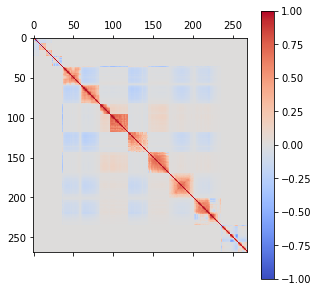

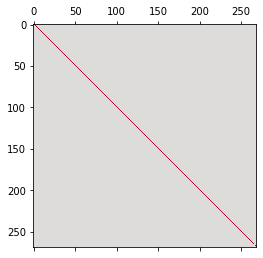

In [11]:
plt.matshow(data_cor, norm=colors.CenteredNorm(), cmap="coolwarm")
plt.colorbar()
plt.matshow(data_cor > 0.999, norm=colors.CenteredNorm(), cmap="coolwarm")

In [12]:
np.where(data_cov> 5e-2)

(array([  0,  24,  36, 235]), array([  0,  24,  36, 235]))

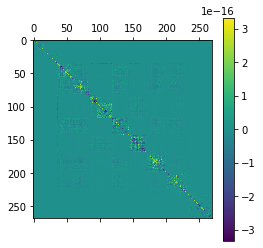

In [13]:
def cov_to_cor(cov):
    sigma = np.sqrt(np.diag(cov))
    cor = cov / sigma[np.newaxis, :] / sigma[:, np.newaxis]
    return cor
plt.matshow(cov_to_cor(data_cov) - data_cor)
plt.colorbar()

In [14]:
blocks = []
cor = data_cor
while len(cor):
    i = np.where(cor[0] == 0)[0]
    if len(i) == 0:
        blocks.append(len(cor))
        break
    else:
        blocks.append(i[0])
        cor = cor[i[0] :, :][:, i[0] :]

del cor

In [15]:
blocks

[24, 12, 199, 34]

In [16]:
i = 0
k = np.sum(blocks)
for j, n in enumerate(sorted(blocks)[::-1]):
    i += (j + 1) * n
i /= k
np.sqrt(1 + 120 * (i - np.sqrt(i)) / (k + 25))

1.0476834427019623

In [17]:
data_cov_nan = np.full_like(data_cov, np.nan)
data_cor_nan = np.full_like(data_cor, np.nan)
i = 0
for b in blocks:
    data_cov_nan[i : i + b, :][:, i : i + b] = data_cov[i : i + b, :][:, i : i + b]
    data_cor_nan[i : i + b, :][:, i : i + b] = data_cor[i : i + b, :][:, i : i + b]
    i += b

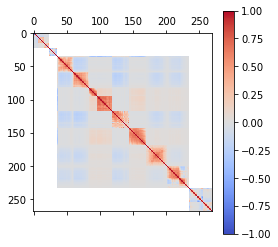

In [18]:
plt.matshow(data_cor_nan, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [19]:
np.nanmax(np.abs(data_cor_nan - data_cor_nan.T))

0.0

In [20]:
ret = {}
a = derate_covariance(
    data_cor_nan, return_dict=ret, whitening="zca_aligned"
)
a

1.0943190359044617

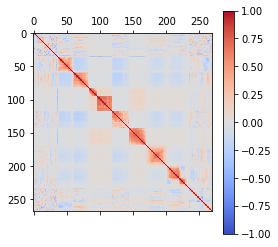

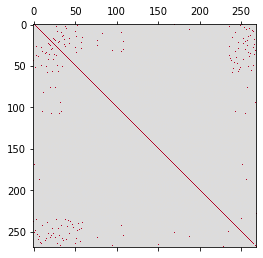

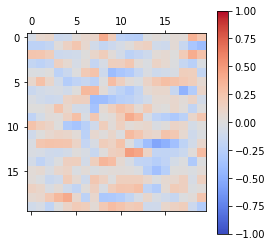

In [21]:
c = ret["nightmare_cov"]
plt.matshow(c, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()
W = ret["W"]
plt.matshow((W @ c @ W.T), vmin=-1, vmax=1, cmap="coolwarm")
plt.matshow(c[:20, -20:], vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [22]:
ret0 = {}
a = derate_covariance(
    data_cov_nan, return_dict=ret0, whitening="zca_aligned"
)
a

1.089022081404001

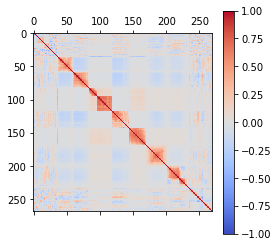

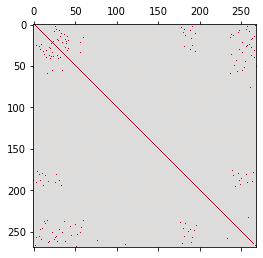

In [23]:
c = ret0["nightmare_cov"]
cor = cov_to_cor(c)
plt.matshow(cor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()
W = ret0["W"]
plt.matshow((W @ c @ W.T), vmin=-1, vmax=1, cmap="coolwarm")

In [24]:
%%time
derate_covariance(data_cov_nan, whitening="cholesky")

CPU times: user 5.21 s, sys: 2.1 s, total: 7.31 s
Wall time: 4.58 s


1.0936355935499256

In [25]:
derate_covariance(data_cov_nan, whitening="zca_aligned", method="gx2")

1.089022081404001

In [26]:
A = np.loadtxt("genie-tune/jacobian_postfix.dat")[:, param_used]

In [27]:
A.shape

(269, 6)

In [28]:
A[0]

array([-0.05986994, -0.11009392,  0.03263643, -0.12992033, -0.0140465 ,
       -0.37396511])

In [29]:
data_used_red = []
with open("genie-tune/data_no_syst.weight_26", "rt") as f:
    for line in f:
        if line.startswith("/global#"):
            field = line.split()
            imin, imax = field[0].split("#")[1].split(":")
            used = float(field[1]) > 0.5
            for _ in range(int(imin), int(imax)):
                data_used_red.append(used)
data_used_red = np.array(data_used_red)
print(len(data_used_red), np.sum(data_used_red))

269 98


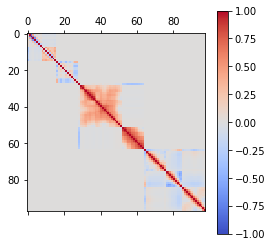

In [30]:
data_cov_red = data_cov_nan[data_used_red,:][:,data_used_red]
data_cor_red = data_cor[data_used_red,:][:,data_used_red]
plt.matshow(data_cor_red, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [31]:
ret_red = {}
derate_covariance(data_cov_red, jacobian=A[data_used_red], return_dict=ret_red)

2.316650619644164

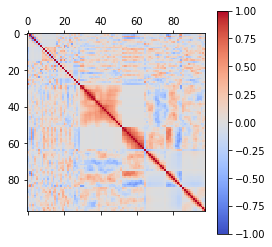

In [32]:
nightmare_cor_red = cov_to_cor(ret_red["nightmare_cov"])
plt.matshow(nightmare_cor_red, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [33]:
full_fit_result_file = up.open("genie-tune/result_test_comb_15.root")

In [34]:
full_fit_result_file.items()

[('param_results;1', <TVectorT<double> (version 4) at 0x7f6ac43e1940>),
 ('h_param_result;1', <TH1D (version 2) at 0x7f6ac43e1c70>),
 ('param_covariance;1', <TMatrixTSym<double> (version 5) at 0x7f6ac43e1610>),
 ('global_pred_cov;1', <TMatrixTSym<double> (version 5) at 0x7f6ac43ef3d0>),
 ('global_pred_MC_err;1', <TH1D (version 2) at 0x7f6ac43ef3a0>),
 ('global_pred_sys_err;1', <TH1D (version 2) at 0x7f6ac43ef7c0>),
 ('h_global_pred_cov;1', <TH2D (version 3) at 0x7f6ac43f2910>),
 ('h_global_pred_cor;1', <TH2D (version 3) at 0x7f6ac43f9a60>),
 ('h_param_covariance;1', <TH2D (version 3) at 0x7f6ac437ec40>),
 ('h_param_correlation;1', <TH2D (version 3) at 0x7f6ac4383e20>)]

In [35]:
full_param_result = full_fit_result_file["h_param_result"].values()
full_param_cov = full_fit_result_file["h_param_covariance"].values()

In [36]:
full_param_result

array([1.10836403, 0.17212304, 1.53233169, 0.6706714 , 1.58794822,
       0.90426555, 1.1191042 , 1.19606893, 1.41223647, 1.26262667,
       0.28092843, 1.26716833, 0.30149474, 0.01131865])

In [37]:
B = np.loadtxt("genie-tune/full_jacobian.dat")

In [38]:
data_used_full = []
with open("genie-tune/data_no_syst.weight_15", "rt") as f:
    for line in f:
        if line.startswith("/global#"):
            field = line.split()
            imin, imax = field[0].split("#")[1].split(":")
            used = float(field[1]) > 0.5
            for _ in range(int(imin), int(imax)):
                data_used_full.append(used)
data_used_full = np.array(data_used_full)
print(len(data_used_full), np.sum(data_used_full))

269 72


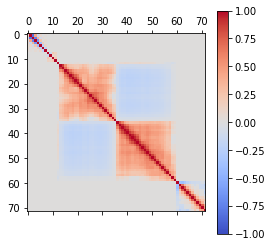

In [39]:
data_cov_full = data_cov_nan[data_used_full,:][:,data_used_full]
data_cor_full = data_cor[data_used_full,:][:,data_used_full]
plt.matshow(data_cor_full, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [40]:
ret_full = {}
derate_covariance(data_cov_full, jacobian=B[data_used_full], return_dict=ret_full)

1.6150625862602748

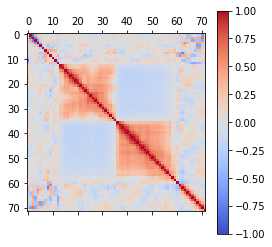

In [41]:
nightmare_cor_full = cov_to_cor(ret_full["nightmare_cov"])
plt.matshow(nightmare_cor_full, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [42]:
raw_data_file = up.open("genie-tune/data_no_syst.root")

In [43]:
raw_data_file.items()

[('global;1', <TH1D (version 3) at 0x7f6ac4297460>),
 ('global_cov;1', <TMatrixTSym<double> (version 5) at 0x7f6ac41eb9d0>),
 ('h_global_cov;1', <TH2D (version 4) at 0x7f6ac412dac0>),
 ('h_global_cor;1', <TH2D (version 4) at 0x7f6ac412dd30>)]

In [44]:
raw_data_cor = raw_data_file["h_global_cor"]

In [45]:
raw_data_cov = raw_data_file["h_global_cov"].values()
raw_data_cor = raw_data_file["h_global_cor"].values()
raw_data_cov = (raw_data_cov + raw_data_cov.T) / 2
raw_data_cor = (raw_data_cor + raw_data_cor.T) / 2
raw_data_cor.shape

(269, 269)

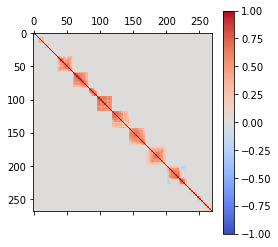

In [46]:
plt.matshow(raw_data_cor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [47]:
raw_data = raw_data_file["global"].values()
norm_shape_jacobian_list = []
i = 0
for b in blocks:
    dat = raw_data[i:i+b]
    norm = np.sum(dat)
    jac = np.zeros((b,b))
    for j in range(b):
        for k in range(b):
            if j == 0:
                jac[j,k] = 1
            else:
                jac[j,k] = (j==k)/norm - dat[j]/norm**2
    norm_shape_jacobian_list.append(jac)
    i += b

norm_shape_jacobian = block_diag(*norm_shape_jacobian_list)

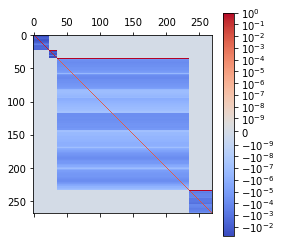

In [48]:
plt.matshow(norm_shape_jacobian, norm=colors.SymLogNorm(linthresh=1e-9), cmap="coolwarm")
plt.colorbar()

In [49]:
#infl = block_diag(*(np.ones((b,b))*2e-2 for b in blocks))
#test_cov = norm_shape_jacobian @ (raw_data_cov+infl) @ norm_shape_jacobian.T
test_cov = norm_shape_jacobian @ (raw_data_cov) @ norm_shape_jacobian.T
test_cor = cov_to_cor(test_cov)

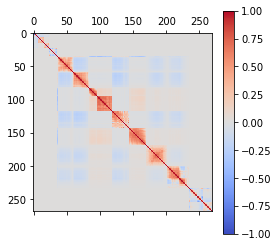

In [50]:
plt.matshow(test_cor, norm=colors.CenteredNorm(), cmap="coolwarm")
plt.colorbar()

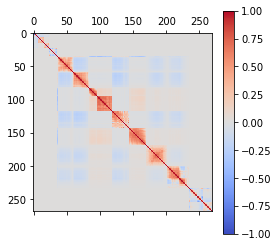

In [51]:
plt.matshow(data_cor, norm=colors.CenteredNorm(), cmap="coolwarm")
plt.colorbar()

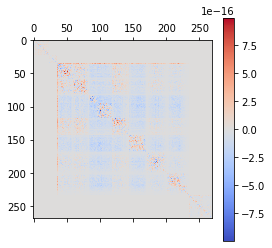

In [52]:
plt.matshow(data_cor-test_cor, norm=colors.CenteredNorm(), cmap="coolwarm")
plt.colorbar()

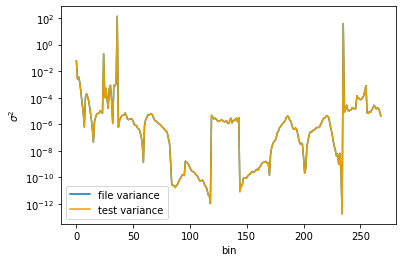

In [53]:
plt.plot(np.diag(data_cov), label="file variance")
plt.plot(np.diag(test_cov), label="test variance")
plt.yscale("log")
plt.xlabel("bin")
plt.ylabel(r"$\sigma^2$")
plt.legend()

In [54]:
raw_blocks = []
cor = raw_data_cor
while len(cor):
    i = np.where(cor[0] == 0)[0]
    if len(i) == 0:
        raw_blocks.append(len(cor))
        break
    else:
        raw_blocks.append(i[0])
        cor = cor[i[0] :, :][:, i[0] :]

del cor

In [55]:
raw_blocks

[8, 8, 8, 5, 4, 3, 24, 24, 12, 23, 25, 26, 32, 33, 12, 9, 13]

In [56]:
raw_data_cov_nan = np.full_like(data_cov, np.nan)
raw_data_cor_nan = np.full_like(data_cor, np.nan)
i = 0
for b in raw_blocks:
    raw_data_cov_nan[i : i + b, :][:, i : i + b] = raw_data_cov[i : i + b, :][:, i : i + b]
    raw_data_cor_nan[i : i + b, :][:, i : i + b] = raw_data_cor[i : i + b, :][:, i : i + b]
    i += b

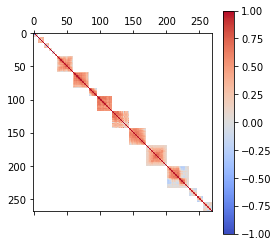

In [57]:
plt.matshow(raw_data_cor_nan, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [58]:
raw_data_cov_nan_paper_uncor = np.full_like(data_cov, np.nan)
raw_data_cor_nan_paper_uncor = np.full_like(data_cor, np.nan)
i = 0
for b in blocks:
    raw_data_cov_nan_paper_uncor[i : i + b, :][:, i : i + b] = raw_data_cov[i : i + b, :][:, i : i + b]
    raw_data_cor_nan_paper_uncor[i : i + b, :][:, i : i + b] = raw_data_cor[i : i + b, :][:, i : i + b]
    i += b

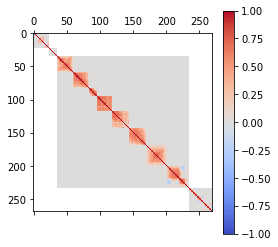

In [59]:
plt.matshow(raw_data_cor_nan_paper_uncor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [60]:
raw_data_cov_nan_exp_uncor = np.full_like(data_cov, np.nan)
raw_data_cor_nan_exp_uncor = np.full_like(data_cor, np.nan)
i = 0
for b in raw_blocks:
    raw_data_cov_nan_exp_uncor[i : i + b, :][:, i : i + b] = raw_data_cov[i : i + b, :][:, i : i + b]
    raw_data_cor_nan_exp_uncor[i : i + b, :][:, i : i + b] = raw_data_cor[i : i + b, :][:, i : i + b]
    i += b
for i in range(np.sum(blocks[:2])):
    for j in range(np.sum(blocks[:2]), np.sum(blocks)):
        raw_data_cov_nan_exp_uncor[i,j] = 0
        raw_data_cov_nan_exp_uncor[j,i] = 0
        raw_data_cor_nan_exp_uncor[i,j] = 0
        raw_data_cor_nan_exp_uncor[j,i] = 0

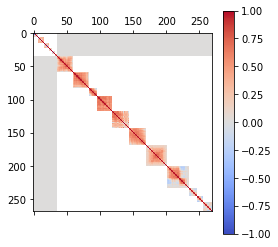

In [61]:
plt.matshow(raw_data_cor_nan_exp_uncor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [62]:
derate_covariance(raw_data_cov_nan)

1.6073648628209039

In [63]:
derate_covariance(raw_data_cov_nan_paper_uncor)

1.0943190359035508

In [64]:
derate_covariance(raw_data_cov_nan_exp_uncor)

1.4644788540623848

In [65]:
norm_shape_inv = np.linalg.inv(norm_shape_jacobian)

In [66]:
raw_A = norm_shape_inv @ A

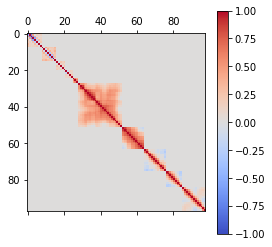

In [67]:
raw_data_cov_red = raw_data_cov_nan[data_used_red,:][:,data_used_red]
raw_data_cov_red_paper_uncor = raw_data_cov_nan_paper_uncor [data_used_red,:][:,data_used_red]
raw_data_cov_red_exp_uncor = raw_data_cov_nan_exp_uncor [data_used_red,:][:,data_used_red]
raw_data_cor_red = raw_data_cor[data_used_red,:][:,data_used_red]
plt.matshow(raw_data_cor_red, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()
plt.savefig("plots/genie-cor-red.pdf")

In [68]:
raw_ret_red = {}
derate_covariance(raw_data_cov_red, jacobian=raw_A[data_used_red], return_dict=raw_ret_red)

3.869277466958558

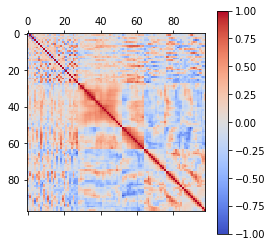

In [69]:
raw_nightmare_cor_red = cov_to_cor(raw_ret_red["nightmare_cov"])
plt.matshow(raw_nightmare_cor_red, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()
plt.savefig("plots/genie-cor-red-max.pdf")

In [70]:
raw_ret_red_paper_uncor = {}
derate_covariance(raw_data_cov_red_paper_uncor, jacobian=raw_A[data_used_red], return_dict=raw_ret_red_paper_uncor)

2.3184225836986294

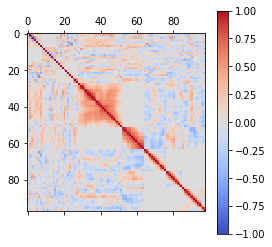

In [71]:
raw_nightmare_cor_red_paper_uncor = cov_to_cor(raw_ret_red_paper_uncor["nightmare_cov"])
plt.matshow(raw_nightmare_cor_red_paper_uncor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [72]:
raw_ret_red_exp_uncor = {}
derate_covariance(raw_data_cov_red_exp_uncor, jacobian=raw_A[data_used_red], return_dict=raw_ret_red_exp_uncor)

2.695274734921891

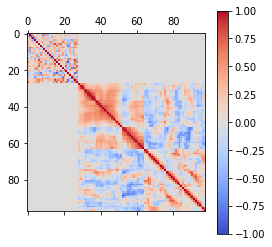

In [73]:
raw_nightmare_cor_red_exp_uncor = cov_to_cor(raw_ret_red_exp_uncor["nightmare_cov"])
plt.matshow(raw_nightmare_cor_red_exp_uncor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()
plt.savefig("plots/genie-cor-red-exp.pdf")

In [74]:
raw_B = norm_shape_inv @ B

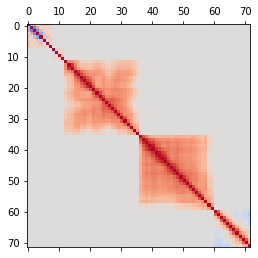

In [75]:
raw_data_cov_full = raw_data_cov_nan[data_used_full,:][:,data_used_full]
raw_data_cov_full_paper_uncor = raw_data_cov_nan_paper_uncor [data_used_full,:][:,data_used_full]
raw_data_cov_full_exp_uncor = raw_data_cov_nan_exp_uncor [data_used_full,:][:,data_used_full]
raw_data_cor_full = raw_data_cor[data_used_full,:][:,data_used_full]
plt.matshow(raw_data_cor_full, vmin=-1, vmax=1, cmap="coolwarm")
#plt.colorbar()
plt.savefig("plots/genie-cor-all.pdf")

In [76]:
raw_ret_full = {}
derate_covariance(raw_data_cov_full, jacobian=raw_A[data_used_full], return_dict=raw_ret_full)

2.6885815537604554

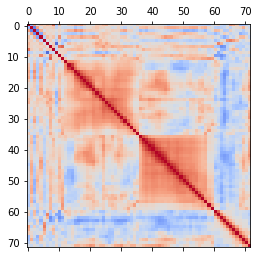

In [77]:
raw_nightmare_cor_full = cov_to_cor(raw_ret_full["nightmare_cov"])
plt.matshow(raw_nightmare_cor_full, vmin=-1, vmax=1, cmap="coolwarm")
#plt.colorbar()
plt.savefig("plots/genie-cor-all-max.pdf")

In [78]:
raw_ret_full_paper_uncor = {}
derate_covariance(raw_data_cov_full_paper_uncor, jacobian=raw_A[data_used_full], return_dict=raw_ret_full_paper_uncor)

1.9095949455678212

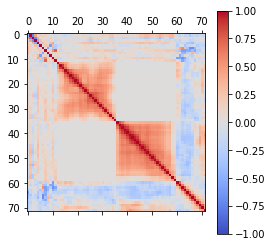

In [79]:
raw_nightmare_cor_full_paper_uncor = cov_to_cor(raw_ret_full_paper_uncor["nightmare_cov"])
plt.matshow(raw_nightmare_cor_full_paper_uncor, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

In [80]:
raw_ret_full_exp_uncor = {}
derate_covariance(raw_data_cov_full_exp_uncor, jacobian=raw_A[data_used_full], return_dict=raw_ret_full_exp_uncor)

2.072487646122324

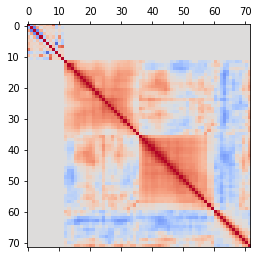

In [81]:
raw_nightmare_cor_full_exp_uncor = cov_to_cor(raw_ret_full_exp_uncor["nightmare_cov"])
plt.matshow(raw_nightmare_cor_full_exp_uncor, vmin=-1, vmax=1, cmap="coolwarm")
#plt.colorbar()
plt.savefig("plots/genie-cor-all-exp.pdf")